# Author: Lena Noack
# GNU General Public License v3.0 (GPL-3.0)
#Interior Structure Model


In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from EOS_functions import EOS_rock, EOS_core, EOS_core_mixed
from values import *
from Help_functions import get_Tmelt_MO, get_Tmelt_core, get_Tmelt_water, getphase
from water import getWater


##Start interior structure model




In [10]:
def interior_structure(M,x_Fe_tot,x_H2O_tot=0.0):
  '''
  input:
   M: Mass in Earth masses
   x_Fe_tot: Iron weigth fraction in percent of the entire planet (core + mantle)
   x_H2O_tot: Water weigth fraction in percent of surface water/ice layer
  return:
   Rp_E - planet radius in Earth radii
   MOI - moment of inertia factor
   radius,density,gravity,pressure,temperature,alpha,cp,mass,elcond,vP,vS,KT,KS,mu - profiles of different planetary properties
   mat - material layers (<0 ices, 0 water, >0 different rock and core layers)
  '''

  '''Set initialization parameters'''
  Dcr = 50e3      # thickness of crustal layer in m
  Dlid = 300e3    # thickness of lithosphere, only used to set upper mantle temperature
  Psurf = 1e5     # atmospheric surface pressure
  Tsurf = 300     # potential surface temperature in K
  Tlid = 0.0    #2000 # in K; if set to 0, then mantle melt temp is used at Dlid depth to set Tlid
  DTcmb = -1.0  #1500 # in K, T jump at CMB; if set to neg value (e.g. -1), then jump is calculated via melt temp times -DTcmb
  nr = 500         # radial resolution from center of planet to surface
  tol = 0.001     # Convergence parameter
  maxIter = 20   # max number iterations

  # light elements in the core -> array added for molar fractions Si,C,S,O; e.g. (0.2 S -> Fe0.8S0.2), means weight fraction of 12 wt-% S
  xelem = np.array([0.0,0.0,0.2,0.0]) # initial core-averaged value
  xelem_ic = np.array([0.00,0.00,0.07,0.00]) # fixed inner core value (no real partitioning included yet; outer core value calculated during inner core growth

  X_FeM_mol = 0.1 # iron number in mantle (ratio of Fe-bearing molecules divided by Mg- and Fe-bearing molecules)
  X_H2OM = 0      # water content in mantle in wt-%, only used for el cond profile versions 2-4
  ec_model = 1    # electrical conductivity profiles: 1 - Xu, 2 - mat-dep prof without Fe, 3 - as 2 but with Fe dependence, 4 - as 3 but newer parameters


  '''Distribute iron between core and mantle'''

  x_Fe_tot = x_Fe_tot/100 # weight fraction instead of percent
  x_H2O_tot = x_H2O_tot/100
  M = M * 5.972*10**24 # mass in kg
  Mw = M*x_H2O_tot # would need to be reduced by water stored in mantle, not considered here
  G = 6.67384*10**(-11) # gravitational constant in m^3 / (kg s^2)

  # Take Fe in mantle out of x_Fe to obtain x_CMF (core mass fraction based on iron - here light elements not included yet!)
  # Here we assume that mantle is composed of (1-X_FeM_mol)*Mg2SiO4 + X_FeM_mol*Fe2SiO4

  # Molar masses:
  mMg=24.305; mFe=55.845; mSi=28.0855; mO=15.9994

  XmFe = 2*X_FeM_mol*mFe/(X_FeM_mol*2*(mFe-mMg) + 2*mMg+mSi+4*mO) # mantle mass fraction of iron w.r.t. mantle mass

  # x_Fe_tot*M = x_Fe*M + XmFe*Mm = x_Fe*M*(1-XmFe) + XmFe*(M-Mw)
  x_Fe = ( x_Fe_tot*M - XmFe*(M-Mw) ) / (M*(1-XmFe)) # core mass fraction w.r.t. total planet mass
  Mc = x_Fe*M
  if Mc<0.0:
      print("Error, not enough iron in planet to have ",X_FeM_mol," as iron number -> adapt iron number!")
      Mc = 0.0
      x_Fe = 0.0
      XmFe = x_Fe_tot*M / (M-Mw) # adapt XmFe such that all iron is in mantle

      #XmFe * (X_FeM_mol*2*(mFe-mMg) + 2*mMg+mSi+4*mO) = 2*X_FeM_mol*mFe
      X_FeM_mol = XmFe*(2*mMg+mSi+4*mO)/(2*mFe-2*(mFe-mMg)*XmFe) # adapt mantle iron number

  Mm = M - Mc - Mw

  #print('Iron fraction={0:5.3f}, Core IF={1:5.3f}, Mantle Fe#={2:5.3f}, Mantle IF={3:5.3f}\n'
  #      .format(x_Fe_tot,x_Fe,X_FeM_mol,XmFe*Mm/M))

  '''Initialization routines'''

  rho_c = 11000 # guess for core density in kg/m^3
  rho_m = 4000 # guess for mantle density in kg/m^3
  rho_w = 1000 # guess for water density in kg/m^3
  cp_c = 800 # guess for core heat capacity in J/kg K
  cp_m = 1300 # guess for mantle heat capacity in J/kg K
  cp_w = 4200 # guess for water heat capacity in J/kg K
  alpha_c = 0.00001 # guess for core thermal expansion ceoff. in 1/K
  alpha_m = 0.000025 # guess for mantle thermal expansion ceoff. in 1/K
  alpha_w = 0.00007 # guess for water thermal expansion ceoff. in 1/K

  Rc = ( Mc*3.0 / (4.0*math.pi*rho_c) )**(1/3) # first guess core radius
  Rm = ( Mm*3.0 / (4.0*math.pi*rho_m) + Rc**3 )**(1/3) # first guess rocky shell radius
  Rp = ( Mw*3.0 / (4.0*math.pi*rho_w) + Rm**3 )**(1/3) # first guess planet radius

  # Define arrays
  dr = np.zeros(nr) # distance between radius points
  radius = np.zeros(nr) # vector of radii, first radius is dr
  pressure = np.zeros(nr)
  gravity = np.zeros(nr)
  temperature = np.zeros(nr)
  density = np.zeros(nr)
  alpha = np.zeros(nr)
  cp = np.zeros(nr)
  KT = np.zeros(nr)
  KS = np.zeros(nr)
  mu = np.zeros(nr)
  mass = np.zeros(nr)
  mat = np.zeros(nr)
  elcond = np.zeros(nr)

  # set number of grid points in the three layers (core/mantle/water) based on initial radii, to be kept constant throughout iteration
  nc = int(nr * Rc/Rp)
  if (x_H2O_tot==0):
    nm = nr - nc
    nw = 0
  else:
    nm = int(nr * Rm/Rp) - nc
    nw = nr - nm - nc

  # Initialization of arrays: surface values
  if Mw>0:
    density[nr-1] = rho_w
    alpha[nr-1] = alpha_w
    cp[nr-1] = cp_w
  elif Mm>0:
    density[nr-1] = rho_m
    alpha[nr-1] = alpha_m
    cp[nr-1] = cp_m
  else: # pure iron shell
    density[nr-1] = rho_c
    alpha[nr-1] = alpha_c
    cp[nr-1] = cp_c
    Rc = Rp

  # Initialization of arrays: interpolation over depth
  for i in range(0,nr):
    if i==0:
      r_prev = 0.0
    else:
      r_prev = radius[i-1]
    if i<nc:
      dr[i] = Rc/float(nc)
      density[i] = rho_c
      alpha[i] = alpha_c
      cp[i] = cp_c
    elif i<nc+nm:
      dr[i] = (Rm-Rc)/float(nm)
      density[i] = rho_m
      alpha[i] = alpha_m
      cp[i] = cp_m
    else:
      dr[i] = (Rp-Rm)/float(nw)
      density[i] = rho_w
      alpha[i] = alpha_w
      cp[i] = cp_w
    radius[i] = r_prev + dr[i]


  # pressure and temperature are interpolated from surface downwards
  # gravity has boundary condition 0 in center (and not at surface)
  pressure[nr-1] = Psurf # 1 bar surface pressure
  temperature[nr-1] = Tsurf # surface temperature
  gravity[nr-1] = G*M/Rp**2 # first guess surface gravity
  plid = Dlid*rho_m*gravity[nr-1] # first guess at plid, will be calculated below


  '''Start iteration to determine interior structure'''

  #print('It  Rp/1000  Rc/1000  rho_m  rho_c')
  #print('------------------------------------')

  iter = 1
  Store_V_vec_old = []
  Rp_old = 0
  while (abs(Rp-Rp_old) > tol) and (iter < maxIter):
      # store old Rp value to determine convergence
      Rp_old = Rp

      # average values will be re-determined from material properties
      rho_c = 0; rho_m = 0; rho_w = 0; vol_c = 0; vol_m = 0; vol_w = 0

      # update vectors for radius, gravity, pressure and temperature
      for i in range(0,nr):
        if i==0:
          r_prev = 0.0
        else:
          r_prev = radius[i-1]
        if i<nc:
          dr[i] = Rc/float(nc)
        elif i<nc+nm:
          dr[i] = (Rm-Rc)/float(nm)
        else:
          dr[i] = (Rp-Rm)/float(nw)
        radius[i] = r_prev + dr[i]
      #print('Rp:',Rp,radius[nr-1],' Rc:',Rc,radius[nc-1],nr,nc,nm,nw)

      # set gravity[0] with formula for homogeneous shell in center (formula below does only work for i>=1)
      gravity[0] = radius[0] * 4/3*math.pi*G*density[0]
      for i in range(1,nr):
          gravity[i] = gravity[i-1] + dr[i-1] * (4*math.pi*G*density[i-1] - 2*gravity[i-1]/radius[i-1])

      for i in range(nr-2,-1,-1):
          pressure[i] = pressure[i+1] + dr[i]*gravity[i]*density[i]
          if i>=nc+nm: # ocean layer, we assume here adiabatic profile from the surface
              temperature[i] = temperature[i+1] + dr[i]*alpha[i+1]/cp[i+1] * gravity[i+1]*temperature[i+1]
          elif Rm-radius[i]<Dlid: # in lithosphere
              if Mw>0:
                Ts = temperature[nc+nm]
              else:
                Ts = Tsurf
              if Tlid>0:
                  # linear increase of temperature in lithosphere for simplicity
                  temperature[i] = Ts + (Tlid-Ts)*(radius[nc+nm-1]-radius[i])/Dlid
              else:
                  temperature[i] = Ts + (get_Tmelt_MO(plid)-Ts)*(radius[nc+nm-1]-radius[i])/Dlid
          elif Rm-radius[i+1]<Dlid: # first grid point in mantle
              if Tlid>0:
                  temperature[i] = Tlid # Choose fixed, pre-defined temperature at bottom of lid
              else:
                  temperature[i] = get_Tmelt_MO(plid) # Choose temperature from end of magma ocean phase
              plid = pressure[i] # for next iteration to get T at lithosphere base in case that Tlid=0
          elif (i+1==nc):
              temperature[i] = temperature[i+1] + dr[i]*alpha[i+1]/cp[i+1] * gravity[i+1]*temperature[i+1]
              if DTcmb >= 0:
                  # Choose fixed, pre-defined temperature at Core-Mantle-Boundary (CMB)
                  temperature[i] = temperature[i] + DTcmb
              else:
                  # Choose temperature from end of magma ocean phase, scaled with abs(DTcmb) factor
                  temperature[i] = temperature[i] + (get_Tmelt_MO(pressure[i])-temperature[i]) * abs(DTcmb)
          else: # in convecting mantle or core
              temperature[i] = temperature[i+1] + dr[i]*alpha[i+1]/cp[i+1] * gravity[i+1]*temperature[i+1]
          #print(i,temperature[i],nc,nm,nr)

      # update material properties
      Store_V_vec = []
      ric = 0
      for i in range(nr): # from center to surface
          # get correct layer depending on core size, mantle phase transitions, and crust thickness
          # 7 layers in total: 6-core, 5-ppv, 4-pv, 3-ri, 2-wa, 1-ol, 0-cr
          if i < nc:
              # iron core
              if temperature[i]<get_Tmelt_core(pressure[i]):
                mat[i] = 8 # inner core
                ric = radius[i] # updated until outer core is reached
              else:
                mat[i] = 7 # outer core
              arr_species = ['fehcp']
              mole_vec = [1]
          elif i >= nc+nm:
              # water layer
              mat[i] = 0 # liquid water or water ice, phase defined below
              arr_species = ['h2o']
              [Tm,phase] = get_Tmelt_water(pressure[i])
              mat[i] = -phase # ice phases stored with negative values
              mole_vec = [1]
          elif pressure[i] >= (127 + 0.006*(temperature[i]-2840))*10**9:
              # post-perovskite
              mat[i] = 6
              arr_species = ['mppv', 'fppv','pe','wu']
              mole_vec = [0.5*(1-X_FeM_mol),0.5*(X_FeM_mol),0.5*(1-X_FeM_mol),0.5*(X_FeM_mol)]
          elif pressure[i] >= (22.9 - 0.0025*(temperature[i]-2260))*10**9:
              # perovskite
              mat[i] = 5
              arr_species = ['mgpv', 'fepv','pe','wu']
              mole_vec = [0.5*(1-X_FeM_mol),0.5*(X_FeM_mol),0.5*(1-X_FeM_mol),0.5*(X_FeM_mol)]
          elif (pressure[i] >= (6.2 + 16.7*(1-X_FeM_mol) + 0.005*(temperature[i]-2260))*10**9) & (radius[i] <= Rp-Dcr):
              # ringwoodite
              mat[i] = 4
              arr_species = ['mgri', 'feri']
              mole_vec = [1-X_FeM_mol,X_FeM_mol]
          elif (pressure[i] >= (4.92 + 5.4*(1-X_FeM_mol) + 0.0025*temperature[i])*10**9) & (radius[i] <= Rp-Dcr):
              # wadsleyite
              mat[i] = 3
              arr_species = ['mgwa', 'fewa']
              mole_vec = [1-X_FeM_mol,X_FeM_mol]
          elif radius[i] <= Rp-Dcr:
              # olivine
              mat[i] = 2
              arr_species = ['fo', 'fa']
              mole_vec = [1-X_FeM_mol,X_FeM_mol]
          else:
              # crust
              mat[i] = 1
              arr_species = ['an','di','qtz'] #Anorthite Feldspar Ca[Al2Si2]O8; Diopside CaMgSi2O6; Quartz SiO2
              mole_vec = [0.5, 0.25, 0.25]

          # mole fraction to mass fraction
          molmass = np.zeros(len(mole_vec))
          for k,species in enumerate(arr_species):
              res = values(species) # params for species
              molmass[k] = res.M
          mf_vec = mole_vec*molmass / np.sum(mole_vec*molmass)


          # calculate local thermodynamic properties based on an EOS
          if mat[i] >= 7:
              if mat[i] == 8:
                xelemc = xelem_ic
              else:
                xelemc = (xelem * radius[nc-1]**3 - xelem_ic*ric**3)/(radius[nc-1]**3-ric**3) # redistribute light elements into outer core, keep some in inner core
                # todo: adjust for slightly different density in inner and outer core, since xelemc is molar fraction, hence mass/molMass
              #print(ric,radius[nc],xelem,xelemc,xelem_ic)
              #cp[i],density[i],alpha[i],KT[i],KS[i],mu[i],V_vec = EOS_core(pressure[i]/10**9,temperature[i],xelemc)
              cp[i],density[i],alpha[i],KT[i],KS[i],mu[i],V_vec = EOS_core_mixed(pressure[i]/10**9,temperature[i],xC=xelemc[1], xSi=xelemc[0], xS=xelemc[2], xO=xelemc[3])

          else:
              if Store_V_vec_old == []:
                  cp[i],density[i],alpha[i],KT[i],KS[i],mu[i],V_vec = EOS_rock(pressure[i]/10**9,temperature[i],arr_species,mf_vec)
              else:
                  #print(i,V_vec)
                  cp[i],density[i],alpha[i],KT[i],KS[i],mu[i],V_vec = EOS_rock(pressure[i]/10**9,temperature[i],arr_species,mf_vec,Store_V_vec_old[i])
          Store_V_vec.append(V_vec)

          # check profiles
          #print(iter,radius[i]/1000,gravity[i],pressure[i]/10**9,density[i],temperature[i])

          # update mass vector (used here only for visualization)
          if i==0:
              mass[i] = 4*math.pi*radius[i]**3*density[i]
          else:
              mass[i] = mass[i-1] + (radius[i]-radius[i-1])*4*math.pi*radius[i]**2*density[i]

          #Get new average densities for radius update
          if i==0:
              vol = 4/3 * math.pi * radius[i]**3
          else:
              vol = 4/3 * math.pi * (radius[i]**3 - radius[i-1]**3)

          if i <= nc:
              rho_c = rho_c + density[i]*vol
              vol_c = vol_c + vol
          elif i <= nc+nm:
              rho_m = rho_m + density[i]*vol
              vol_m = vol_m + vol
          else:
              rho_w = rho_w + density[i]*vol
              vol_w = vol_w + vol

      # Error with surface density for iron incl. light species
      if density[nr-1] < 0:
          density[nr-1] = density[nr-2]

      Store_V_vec_old = Store_V_vec

      if vol_c==0:
          vol_c=1 # in case that no core exists
      if vol_m==0:
          vol_m=1 # in case that no mantle exists
      if vol_w==0:
          vol_w=1 # in case that no water layer exists

      rho_c = rho_c / vol_c
      rho_m = rho_m / vol_m
      rho_w = rho_w / vol_w

      # update radius for core and mantle
      if Mc==0:
        Rc = 0
      else:
        Rc = (3*Mc/(4*math.pi*rho_c))**(1/3)
      if Mm==0:
        Rm = Rc
      else:
        if (rho_m>0.0):
          Rm = (Rc**3 + 3*Mm/(4*math.pi*rho_m))**(1/3)
        else:
          Rm = Rc
      if Mw==0:
        Rp = Rm
      else:
        if (rho_w>0.0): # can happen if surface water layer is smaller than resolution between two uppermost grid points
          Rp = (Rm**3 + 3*Mw/(4*math.pi*rho_w))**(1/3)
        else:
          Rp = Rm

      #print('{0:2d} {1:8.2f} {2:8.2f} {3:7.1f} {4:7.1f}'.format(iter,Rp/1000,Rc/1000,rho_m,rho_c))

      iter=iter+1


  '''Post-processing'''

  # Additional properties computed from final iteration (i.e. without influence on interior structure)

  # seismic velocity profiles
  vP = np.sqrt((KS*10**9+4/3*mu*10**9)/density)*10**-3 # in km/s
  vS = np.sqrt(mu*10**9/density)*10**-3 # in km/s

  # electrical conductivity
  kB = 8.61733e-5
  for i in range(nr):
      T = temperature[i]

      if mat[i]<=0:
          elcond[i] = 1.0e-20
      elif mat[i]<=2: # olivine layer and crust
          if ec_model==1:
              # Xu dry profile
              elcond[i] = 10.0**2.69*math.exp(-1.62/(kB*T))
          elif ec_model==2:
              # electrical conductivity in upper mantle following Yoshino and Katsura 2013
              elcond[i] = 10.0**4.73*math.exp(-2.31/(kB*T)) \
              + 10.0**1.9*X_H2OM*math.exp(-(0.92-0.16*X_H2OM**(1.0/3.0))/(kB*T))
          else:
              # electrical conductivity in upper mantle following Yoshino and Katsura 2013 with iron
              elcond[i] = 10.0**4.73*math.exp(-2.31/(kB*T)) \
              + 10.0**2.98*X_FeM_mol*math.exp(-(1.71-2.0*X_FeM_mol**(1.0/3.0))/(kB*T)) \
              + 10.0**1.9*X_H2OM*math.exp(-(0.92-0.16*X_H2OM**(1.0/3.0))/(kB*T))
      elif (mat[i]==3): # wadsleyite layer
          if ec_model==1:
              # Xu dry profile
              elcond[i] = 10.0**3.29*math.exp(-1.29/(kB*T))
          elif ec_model==2:
              # electrical conductivity in upper mantle following Yoshino 2008
              elcond[i] = 399.0*math.exp(-1.49/(kB*T)) \
              + 7.74*X_H2OM*math.exp(-(0.68-0.02*X_H2OM**(1.0/3.0))/(kB*T))
          else:
              # electrical conductivity in upper mantle following Yoshino and Katsura 2013 with iron
              elcond[i] = 10.0**2.46*X_FeM_mol*math.exp(-(1.45-2.0*X_FeM_mol**(1.0/3.0))/(kB*T)) \
              + 10.0**1.4*X_H2OM*math.exp(-(0.83-0.2*X_H2OM**(1.0/3.0))/(kB*T))
      elif (mat[i]==4): # ringwoodite layer
          if ec_model==1:
              # Xu dry profile
              elcond[i] = 10.0**2.92*math.exp(-1.16/(kB*T))
          elif ec_model==2:
              # electrical conductivity in upper mantle following Yoshino 2008
              elcond[i] = 838.0*math.exp(-1.36/(kB*T)) \
              + 27.7*X_H2OM*math.exp(-(1.12-0.67*X_H2OM**(1.0/3.0))/(kB*T))
          elif ec_model==3:
              # electrical conductivity in upper mantle following Yoshino and Katsura 2013 with enthalpy and alpha from Yoshino&Katsura 2009
              elcond[i] = 10042*X_FeM_mol*math.exp(-(2.48-2.25*X_FeM_mol**(1.0/3.0))/(kB*T)) \
              + 10.0**1.44*X_H2OM*math.exp(-(1.12-0.67*X_H2OM**(1.0/3.0))/(kB*T))
          else:
              # electrical conductivity in upper mantle following Yoshino and Katsura 2013 with iron
              elcond[i] = 10.0**2.92*X_FeM_mol*math.exp(-(1.36-2.0*X_FeM_mol**(1.0/3.0))/(kB*T)) \
              + 10.0**1.44*X_H2OM*math.exp(-(1.12-0.67*X_H2OM**(1.0/3.0))/(kB*T))
      elif (mat[i]==5) or (mat[i]==6): # pv or ppv layer
          #  Xu 2000 lower mantle values (for pv, use here the same formula for ppv)
          elcond[i] = 0.6851*10**1.12*math.exp(-0.62/(kB*T)) \
                    + 0.3149*10**2.69*math.exp(-0.85/(kB*T))
      else: # profile not calculated for core, does not matter anyway for induction heating
          elcond[i] = math.nan

  # log10 values; in iron core ec=nan -> log profile is also nan
  elcond = np.log10(elcond)

  # moment of inertia factor

  IntVal = 0
  for i in range(nr):
    IntVal += density[i] * (radius[i]-0.5*dr[i])**4 * dr[i]

  MOI = IntVal * 8*math.pi/(3*M*Rp**2)

  Rc_E = Rc / 6371000
  Rp_E = Rp / 6371000 # radius in Earth radii instead of m

  return Rp_E,MOI,radius,density,gravity,pressure,temperature,alpha,cp,mass,elcond,vP,vS,KT,KS,mu,mat

##Calculate Rp for given M/Fe values

In [11]:
M=1; x_Fe_tot=38; x_H2O_tot=0.023
Rp_E,MOI,radius,density,gravity,pressure,temperature,alpha,cp,mass,elcond,vP,vS,KT,KS,mu,mat = interior_structure(M,x_Fe_tot,x_H2O_tot)
#print(radius)
print('\n{0:6.4f} Earth masses with {1:5.2f}% iron leads to planet radius {2:6.4f} ({3:d} km) with MOI factor {4:5.3f}'
     .format(M,x_Fe_tot,Rp_E,int(Rp_E*6371),MOI))


1.0000 Earth masses with 38.00% iron leads to planet radius 1.0012 (6378 km) with MOI factor 0.331


# Visualization of results

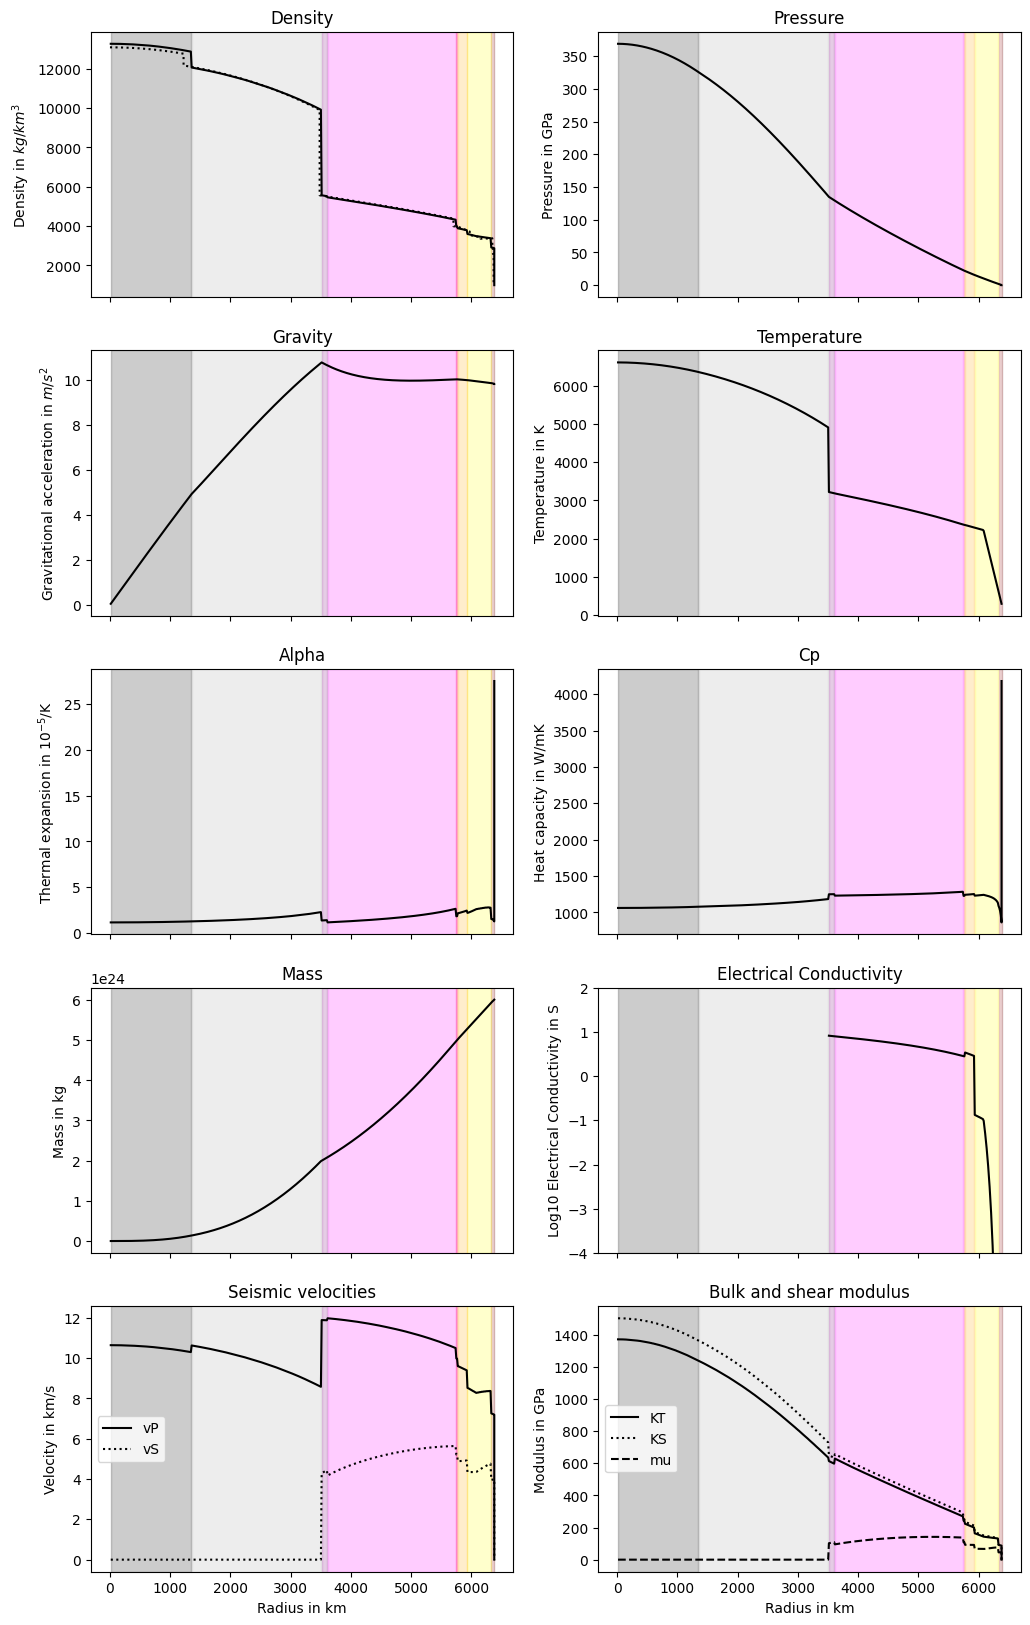

In [12]:
fig, ax = plt.subplots(5,2, sharex=True,figsize=[12,20])

ax[0,0].plot(radius/1000, density, color='black', alpha=1, label="model")
ax[0,0].set_title("Density")
ax[0,0].set_ylabel("Density in $kg/km^3$")

# add PREM values (radius,density,Vpv,Vsv,Q-kappa,Q-mu,Vph,Vsh,eta)
PREM = np.loadtxt('PREM500.csv',delimiter=",") # doi:10.17611/DP/10131390
ax[0,0].plot(PREM[:,0]/1000, PREM[:,1], ':', color='black', alpha=1, label="PREM")

ax[1,0].plot(radius/1000, gravity, color='black', alpha=1)
ax[1,0].set_title("Gravity")
ax[1,0].set_ylabel("Gravitational acceleration in $m/s^2$")

ax[0,1].plot(radius/1000, pressure/10**9, color='black', alpha=1)
ax[0,1].set_title("Pressure")
ax[0,1].set_ylabel("Pressure in GPa")

ax[1,1].plot(radius/1000, temperature, color='black', alpha=1)
ax[1,1].set_title("Temperature")
ax[1,1].set_ylabel("Temperature in K")

ax[2,0].plot(radius/1000, alpha*10**5, color='black', alpha=1)
ax[2,0].set_title("Alpha")
ax[2,0].set_ylabel("Thermal expansion in $10^{-5}$/K")

ax[2,1].plot(radius/1000, cp, color='black', alpha=1)
ax[2,1].set_title("Cp")
ax[2,1].set_ylabel("Heat capacity in W/mK")

ax[3,0].plot(radius/1000, mass, color='black', alpha=1)
ax[3,0].set_title("Mass")
ax[3,0].set_ylabel("Mass in kg")

ax[3,1].plot(radius/1000, elcond, color='black', alpha=1)
ax[3,1].set_title("Electrical Conductivity")
ax[3,1].set_ylabel("Log10 Electrical Conductivity in S")
ax[3,1].set_ylim([-4,2])

ax[4,0].plot(radius/1000, vP, color='black', alpha=1, label='vP')
ax[4,0].plot(radius/1000, vS, ':', color='black', alpha=1, label='vS')
ax[4,0].set_title("Seismic velocities")
ax[4,0].legend()
ax[4,0].set_ylabel("Velocity in km/s")
ax[4,0].set_xlabel("Radius in km")

ax[4,1].plot(radius/1000, KT, color='black', alpha=1, label='KT')
ax[4,1].plot(radius/1000, KS, ':', color='black', alpha=1, label='KS')
ax[4,1].plot(radius/1000, mu, '--', color='black', alpha=1, label='mu')
ax[4,1].legend()
ax[4,1].set_title("Bulk and shear modulus")
ax[4,1].set_ylabel("Modulus in GPa")
ax[4,1].set_xlabel("Radius in km")

for i in range(5):
  for j in range(2):
    cond = np.where(mat==0)[0]
    if (cond.size>0):
        ax[i,j].axvspan(radius[cond[0]]/1000,radius[cond[-1]]/1000, alpha=0.2, color='blue')
    cond = np.where(mat<0)[0]
    if (cond.size>0):
        ax[i,j].axvspan(radius[cond[0]]/1000,radius[cond[-1]]/1000, alpha=0.2, color='grey')
    cond = np.where(mat==1)[0]
    if (cond.size>0):
        ax[i,j].axvspan(radius[cond[0]]/1000,radius[cond[-1]]/1000, alpha=0.2, color='brown')
    cond = np.where(mat==2)[0]
    if (cond.size>0):
        ax[i,j].axvspan(radius[cond[0]]/1000,radius[cond[-1]]/1000, alpha=0.2, color='yellow')
    cond = np.where(mat==3)[0]
    if (cond.size>0):
        ax[i,j].axvspan(radius[cond[0]]/1000,radius[cond[-1]]/1000, alpha=0.2, color='orange')
    cond = np.where(mat==4)[0]
    if (cond.size>0):
        ax[i,j].axvspan(radius[cond[0]]/1000,radius[cond[-1]]/1000, alpha=0.2, color='red')
    cond = np.where(mat==5)[0]
    if (cond.size>0):
        ax[i,j].axvspan(radius[cond[0]]/1000,radius[cond[-1]]/1000, alpha=0.2, color='magenta')
    cond = np.where(mat==6)[0]
    if (cond.size>0):
        ax[i,j].axvspan(radius[cond[0]]/1000,radius[cond[-1]]/1000, alpha=0.2, color='purple')
    cond = np.where(mat==7)[0]
    if (cond.size>0):
        ax[i,j].axvspan(radius[cond[0]]/1000,radius[cond[-1]]/1000, alpha=0.2, color='darkgrey')
    cond = np.where(mat==8)[0]
    if (cond.size>0):
        ax[i,j].axvspan(radius[cond[0]]/1000,radius[cond[-1]]/1000, alpha=0.2, color='black')

#print(mat)